In [17]:
import numpy as np
import matplotlib.pyplot as plt
import math
#define functions required for gmm
 
#multivariate normal func the return probab density
def multivariate(x,mean,cov):
  d=len(x)
  x=np.matrix(x-mean)
  det_cov=np.linalg.det(cov)
  inv_cov=np.linalg.inv(cov)
  prob=np.exp(x*inv_cov*x.T*-0.5)
  prob=prob*1/(math.pow((2*np.pi),d/2)*math.pow(det_cov,0.5))
  return prob
#logliklihood function
def loglike(x,mean,cov,weights):
  r,c=x.shape
  log=0
  for i in range(r):
    p=0
    for k in range(len(weights)):
      p+=weights[k]*multivariate(x[i],mean[k],cov[k])
    log+=np.log(p)
  return log
def posteriorcalc(x,mean,cov,weights):
    r,c =x.shape
    posterior=np.zeros((r,len(weights)))
    for n in range(r):
        for k in range(len(weights)):
            posterior[n,k]=weights[k]*multivariate(x[n],mean[k],cov[k])
        posterior[n] /= posterior[n].sum()
    return posterior
def mx_likelihood(x,posterior):
    r,c=x.shape
    K=posterior.shape[1]
    mean=np.zeros((r,c))
    cov=np.zeros((K,c,c))
    weights=np.zeros(K)
    for k in range(K):
        Nk=posterior[:,k].sum()
        weights[k]=Nk/r
        mean[k]=posterior[:,k].dot(x)/Nk
        for n in range(r):
            xn = X[n]-mean[k]
            cov[k]+=posterior[n,k]*np.outer(xn,xn)
        cov[k]= cov[k]/Nk
    return mean,cov,weights


In [18]:
from sklearn.cluster import KMeans
X = np.loadtxt("dataset4.csv", delimiter=",")
log=[]
posteriors=[]
means=[]
covs=[]
for k in range(2, 7):
    mean=np.array([np.mean(X,axis=0) +np.random.randn(X.shape[1])*0.001 for i in range(k)])
    cov = np.array([np.eye(X.shape[1]) for _ in range(k)])
    weights = np.ones(k) / k
    # Run EM algorithm
    iterations=200
    log_values=np.zeros(iterations)
    for i in range(iterations):
        posterior=posteriorcalc(X,mean,cov,weights)
        mean,cov,weights=mx_likelihood(X,posterior)
        log_values[i]=loglike(X,mean,cov,weights)
        if i>0 and np.abs(log_values[i]-log_values[i-1])<1e-7:
            break
    log.append(log_values[:i+1])
    means.append(mean)
    covs.append(cov)
    posteriors.append(posterior)



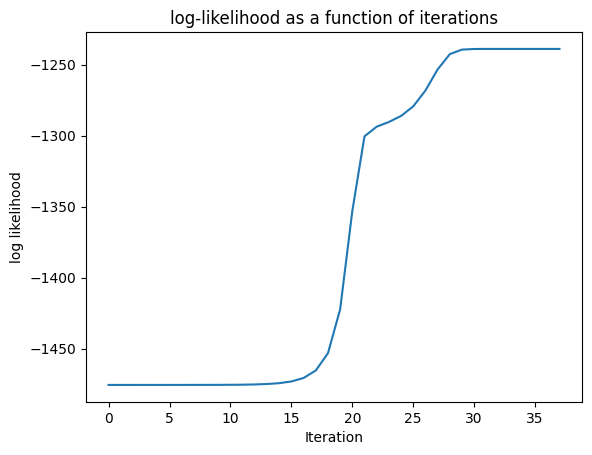

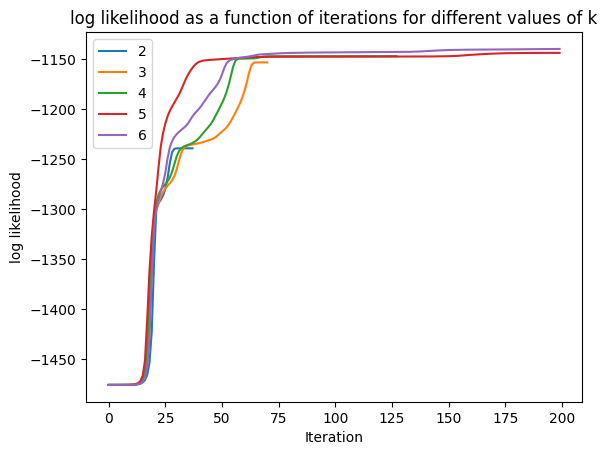

In [19]:
plt.plot(log[0])
plt.xlabel('Iteration')
plt.ylabel('log likelihood')
plt.title('log-likelihood as a function of iterations')
plt.show()
for k in range(len(log)):
  plt.plot(log[k],label=k+2)
plt.xlabel('Iteration')
plt.legend()
plt.ylabel('log likelihood')
plt.title('log likelihood as a function of iterations for different values of k')
plt.show()

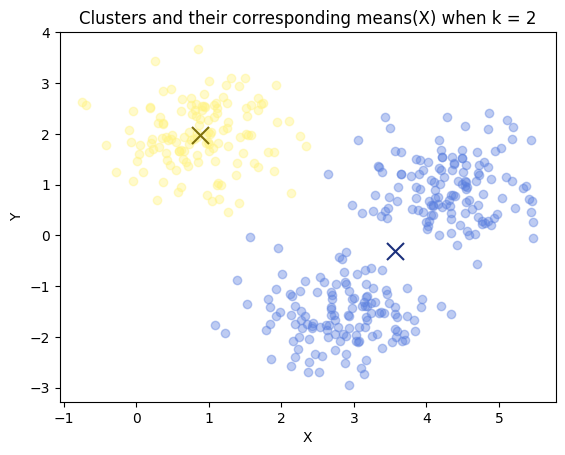

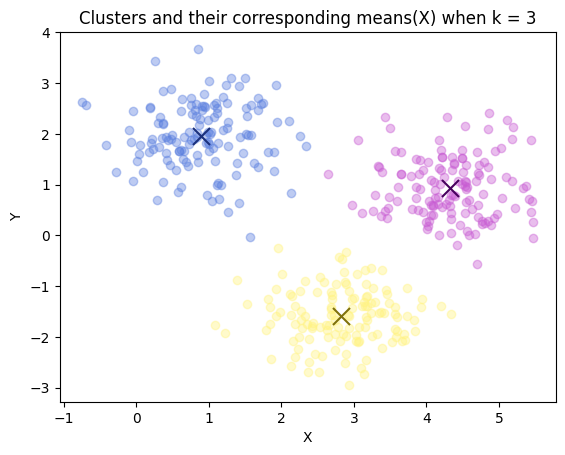

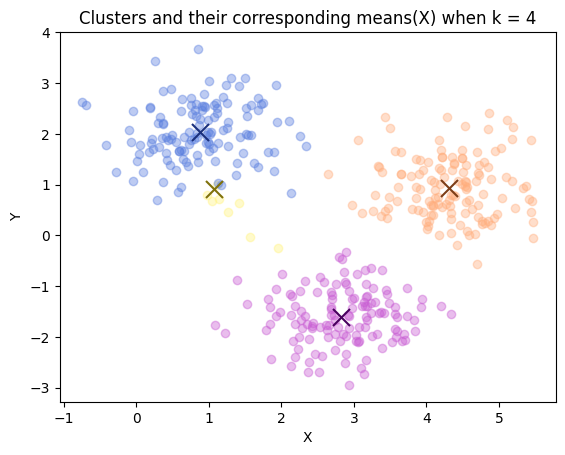

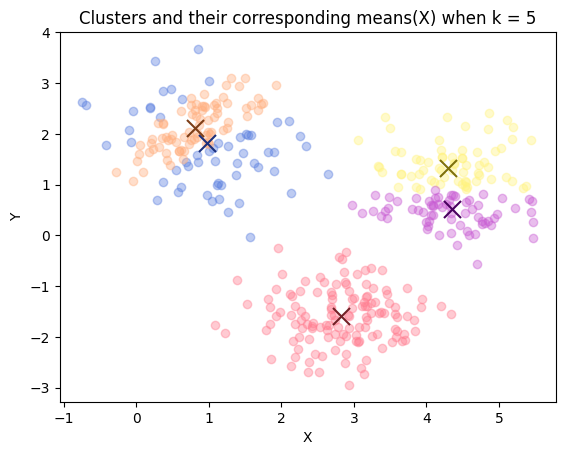

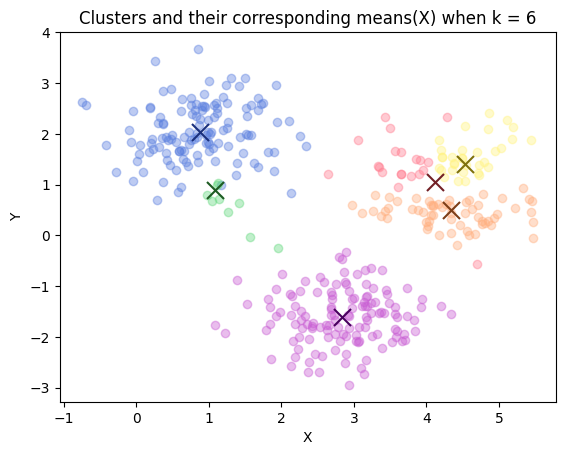

In [20]:
def plot_cluster(X,posterior,mean):
    K=posterior.shape[1]
    color1=['#fff37f', '#5a7fdf', '#c85bd3', '#ffae7d', '#ff7c8f', '#63d87d']
    color2=['#7f710c','#1b307c','#48015e','#7d3e18','#722026','#1e5b23']
    for k in range(K):
        plt.scatter(X[:,0][posterior[:,k]>0.5],X[:,1][posterior[:,k]>0.5],color=color1[k],alpha=0.4)
    for k in range(K):
        plt.scatter(mean[k,0],mean[k,1],color=color2[k],marker='x',s=150)
    
for i in range(len(means)):
  plot_cluster(X,posteriors[i],means[i])
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title(f'Clusters and their corresponding means(X) when k = {i+2}')
  plt.show()

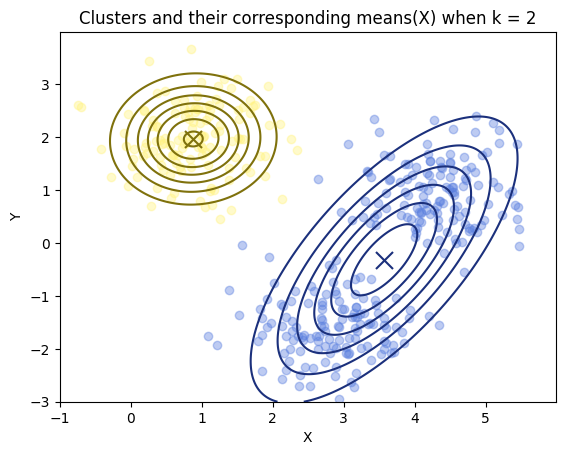

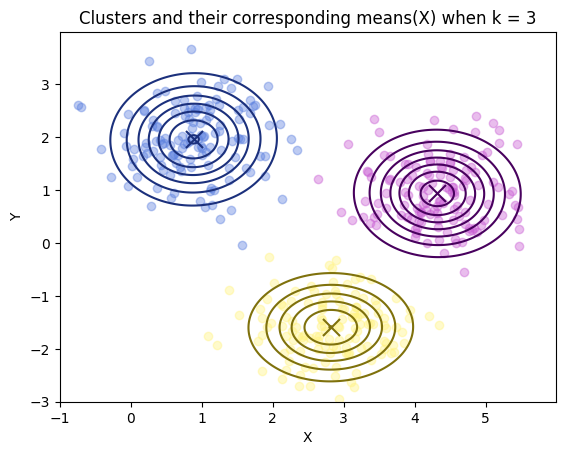

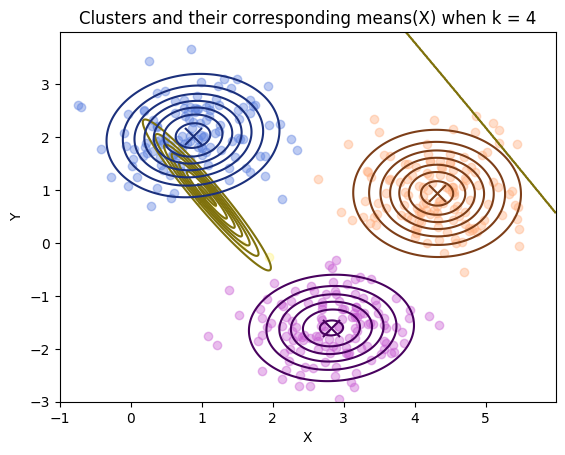

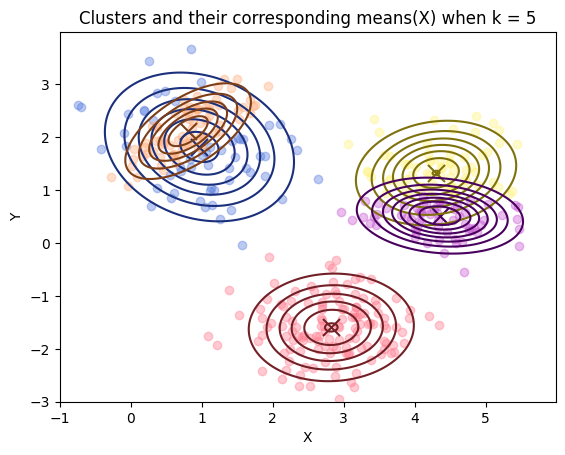

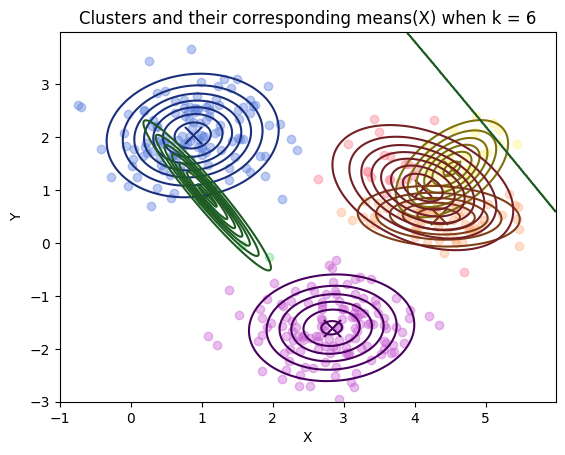

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def plot_cluster(X, posterior, mean, covariance):
    K = posterior.shape[1]
    color1 = ['#fff37f', '#5a7fdf', '#c85bd3', '#ffae7d', '#ff7c8f', '#63d87d']
    color2 = ['#7f710c', '#1b307c', '#48015e', '#7d3e18', '#722026', '#1e5b23']
    for k in range(K):
        plt.scatter(X[:,0][posterior[:,k]>0.5], X[:,1][posterior[:,k]>0.5], color=color1[k], alpha=0.4)
        rv = multivariate_normal(mean=mean[k], cov=covariance[k])
        x, y = np.mgrid[-1:6:.01, -3:4:.01]
        pos = np.dstack((x, y))
        plt.contour(x, y, rv.pdf(pos), colors=color2[k])
    for k in range(K):
        plt.scatter(mean[k,0], mean[k,1], color=color2[k], marker='x', s=150)


for i in range(len(means)):
  plot_cluster(X,posteriors[i],means[i],covs[i])
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title(f'Clusters and their corresponding means(X) when k = {i+2}')
  plt.show()


We can see from the max log likelihood vs k graph that the value increases significantly as we go from 2 to 3 but there isnt any significant change after that.

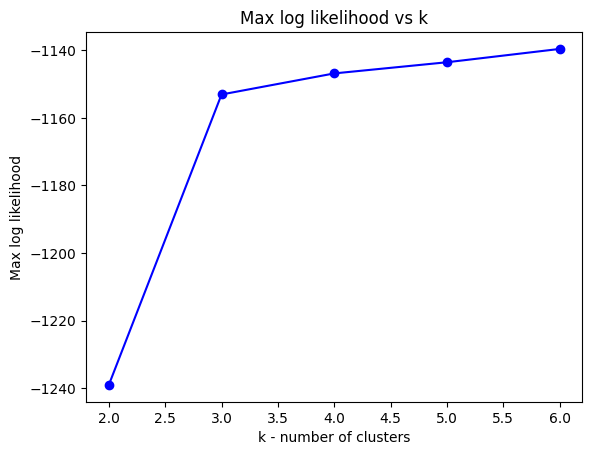

In [22]:
lx=[]
ly=[]
for i in range(len(log)):
  lx.append(i+2)
  ly.append(np.max(log[i]))
plt.plot(lx,ly,"bo-")
plt.xlabel("k - number of clusters")
plt.ylabel("Max log likelihood")
plt.title("Max log likelihood vs k")
plt.show()


BIC is dependent on both how the model fits and the complexity of the model.

low score indicates that the fit is good and the complexity of the model is low 

high score means that the fit is bad and the complexity is higher.

As we can see from the BIC vs k plot for k = 3 we get the lowest value of BIC thus indicating the optimal value of k = 3


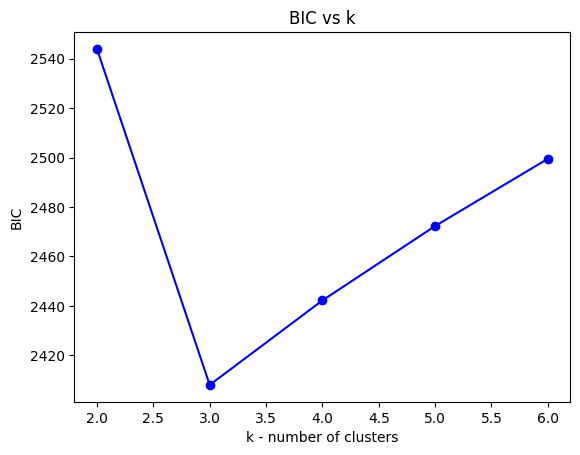

In [23]:
from sklearn.mixture import GaussianMixture
X=np.loadtxt("dataset4.csv",delimiter=",")
b=[]
for k in range(2,7):
    model=GaussianMixture(k)
    model.fit(X)
    b.append(model.bic(X))
plt.plot(range(2,7),b,"bo-")
plt.xlabel("k - number of clusters")
plt.ylabel('BIC')
plt.title("BIC vs k")
plt.show()

Silhouette score tries to compute how close a point is to its own cluster vs other clusters.
it ranges from -1 to 1

A high score indicates that the data points in a cluster are well seperated from other clusters.

From the Silhouette score vs k plot we can see that for k = 3 the score is maximum hence optimal value of k = 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for k=2: 0.54558
Silhouette score for k=3: 0.65867
Silhouette score for k=4: 0.53606
Silhouette score for k=5: 0.41953
Silhouette score for k=6: 0.33195


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


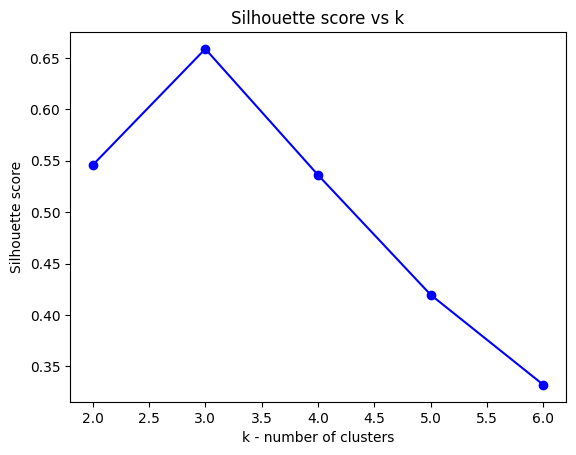

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
X=np.loadtxt("dataset4.csv",delimiter=",")
scores=[]
for k in range(2,7):
    kmeans=KMeans(k).fit(X)
    score=silhouette_score(X,kmeans.labels_)
    scores.append(score)
    print(f"Silhouette score for k={k}: {score:.5f}")
plt.plot(range(2,7),scores,"bo-")
plt.xlabel("k - number of clusters")
plt.ylabel("Silhouette score")
plt.title("Silhouette score vs k")
plt.show()
